In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First thing to do, it is to import the libraries that we'll use on the project.

In [174]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve,plot_roc_curve


In [ ]:
def plot_roc_curve(fpr, tpr):  
  '''
      This Function plot a ROC curve with the auc_score area

      It receives the false positive rate and true positive rate as a parameter
      and return a plot figure
  '''
            plt.plot(fpr, tpr, color='black', label='ROC')
            plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
            plt.fill_between(fpr, tpr, facecolor='lightblue', alpha=0.5)
            plt.text(0.95, 0.05, 'AUC = %0.2f' % auc_curve, ha='right', fontsize=12, weight='bold', color='black')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.legend()
            plt.savefig(f'roc_auc_curve.png')
            plt.show()

Now, I'll proceed to upload our data into dataframes. So we can visualize our data and perform some cleaning, transformation and analysis

In [3]:
df_action = pd.read_csv('/content/drive/MyDrive/HR_Data/tbl_Action.csv', infer_datetime_format=['EffectiveDt'])
df_empl =  pd.read_csv('/content/drive/MyDrive/HR_Data/tbl_Employee.csv', infer_datetime_format = ['EngDt','TermDt','DepID','DOB'])
df_perf = pd.read_csv('/content/drive/MyDrive/HR_Data/tbl_Perf.csv', infer_datetime_format = ['PerfDate'])

Let me see the informations I have on each dataframe

In [ ]:
df_action.head()

,ActID,ActionID,EmpID,EffectiveDt
0,1,10,1,01/Jan/2015
1,2,10,2,01/Jan/2015
2,3,10,3,06/Oct/2015
3,4,10,4,01/Jan/2015
4,5,10,5,22/May/2015


In [ ]:
df_empl

,EmpID,EmpName,EngDt,TermDt,DepID,GenderID,RaceID,MgrID,DOB,Level
0,1,"Nash, Kay K",2015-01-01,2017-05-29,8,1,1,1,1987-02-12,1
1,2,"Simpson, Raymond X",2015-01-01,NaT,7,0,4,2,1982-11-15,1
2,3,"Devlin, Kay M",2015-06-10,2019-06-24,10,1,5,3,1986-02-22,1
3,4,"Massie, Elisabeth V",2015-01-01,NaT,4,1,2,4,1977-05-25,1
4,5,"Mead, Catherine N",2015-05-22,2020-07-15,8,1,1,1,1995-04-04,2
...,...,...,...,...,...,...,...,...,...,...
1557,1558,"Shearer, Dimitrios Q",2023-01-11,NaT,3,0,1,1526,1990-05-21,28
1558,1559,"Shute, Phyllis H",2023-12-07,NaT,1,1,1,1460,1974-10-01,30
1559,1560,"Scholes, Ripduman K",2023-04-22,NaT,1,1,4,1559,1971-05-11,31
1560,1561,"Rawson, Elisabeth K",2023-07-03,NaT,6,1,3,1554,1982-08-25,30


In [ ]:
df_perf

,PerfID,EmpID,Rating,PerfDate
0,1,1,1,31/Dec/2015
1,2,2,2,31/Dec/2015
2,3,3,2,31/Dec/2015
3,4,4,4,31/Dec/2015
4,5,5,2,31/Dec/2015
...,...,...,...,...
9600,9601,1558,3,31/Dec/2023
9601,9602,1559,2,31/Dec/2023
9602,9603,1560,4,31/Dec/2023
9603,9604,1561,2,31/Dec/2023


In [ ]:
df_empl.dtypes

EmpID         int64
EmpName      object
EngDt        object
TermDt       object
DepID         int64
GenderID      int64
RaceID        int64
MgrID         int64
DOB          object
PayRate     float64
Level         int64
dtype: object

# Pre-processing


In order to work and do analysis on the dataframe, first we need to do some changes, cleaning, pre-processing on the data. Below are the transformations that I'll do.

1. Change the date related columns that are currently object type to date type
2. Droping unnecessary columns, i.e, columns that don't have research information values.
3. Merge the employees dataframe and the performance dataframe into one dataframe, that I will call hr_df("human resources dataframe").
4. Deal with NaN values on the dataframe
5. Create additional columns that could enhance our analysis.

Changing the date related columns to date type as they are object types.

In [4]:
df_empl[['EngDt', 'TermDt', 'DOB']]= df_empl[['EngDt', 'TermDt', 'DOB']].apply(pd.to_datetime)

In [5]:
df_perf['PerfDate'] = df_perf['PerfDate'].apply(pd.to_datetime)

In [6]:
df_empl.dtypes

EmpID                int64
EmpName             object
EngDt       datetime64[ns]
TermDt      datetime64[ns]
DepID                int64
GenderID             int64
RaceID               int64
MgrID                int64
DOB         datetime64[ns]
PayRate            float64
Level                int64
dtype: object

So the date columns now are date type, NaN in the TermDt column now changed to NaT(Not a Time).

In [7]:
df_empl

,EmpID,EmpName,EngDt,TermDt,DepID,GenderID,RaceID,MgrID,DOB,PayRate,Level
0,1,"Nash, Kay K",2015-01-01,2017-05-29,8,1,1,1,1987-02-12,NaN,1
1,2,"Simpson, Raymond X",2015-01-01,NaT,7,0,4,2,1982-11-15,NaN,1
2,3,"Devlin, Kay M",2015-06-10,2019-06-24,10,1,5,3,1986-02-22,NaN,1
3,4,"Massie, Elisabeth V",2015-01-01,NaT,4,1,2,4,1977-05-25,NaN,1
4,5,"Mead, Catherine N",2015-05-22,2020-07-15,8,1,1,1,1995-04-04,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...
1557,1558,"Shearer, Dimitrios Q",2023-01-11,NaT,3,0,1,1526,1990-05-21,NaN,28
1558,1559,"Shute, Phyllis H",2023-12-07,NaT,1,1,1,1460,1974-10-01,NaN,30
1559,1560,"Scholes, Ripduman K",2023-04-22,NaT,1,1,4,1559,1971-05-11,NaN,31
1560,1561,"Rawson, Elisabeth K",2023-07-03,NaT,6,1,3,1554,1982-08-25,NaN,30


As the Name and PayRate columns in the employees dataframe, and the PerfID column in the performance dataframe doesn't give us any useful information I will drop them.

In [8]:
df_empl = df_empl.drop(['EmpName','PayRate'], axis = 1)
df_perf = df_perf.drop('PerfID', axis = 1 )

Now I will merge the performance dataframe with the employees dataframe for further analysis. However in order to keep the dataframes with the same number of rows, I'll keep only the last performance data and performance rate for each employee

In [9]:
df_perf = df_perf.sort_values(['EmpID','PerfDate'], ascending=False)

In [10]:
df_perf.drop_duplicates(subset=["EmpID"], inplace=True)

In [11]:
df_perf

,EmpID,Rating,PerfDate
9604,1562,2,2023-12-31
9603,1561,2,2023-12-31
9602,1560,4,2023-12-31
9601,1559,2,2023-12-31
9600,1558,3,2023-12-31
...,...,...,...
4059,5,3,2019-12-31
8488,4,2,2023-12-31
2971,3,4,2018-12-31
8487,2,3,2023-12-31


Merging the two dataframes and creating a new dataframe called hr_df.

In [12]:
hr_df = df_empl.merge(df_perf, on ='EmpID', how ='outer', validate='one_to_one')

As we can see on the df_perf not all employees did a performance test(the dataset has 30 rows less than the df_empl), so on the merge the values of rating, PerfID, and PerfDate will be NaN valus.

In order to change this fact I'll do the following changes, any employee that didn't take a performance test will have the rating as 1, and the date will be the lastest date on the dataset, in this case 2023-12-31.


In [13]:
hr_df['Rating'] = hr_df['Rating'].fillna(1)
hr_df['PerfDate'] = hr_df['PerfDate'].fillna('2023-12-31 00:00:00')


Now I'll add some extra columns that will facilitate the analysis that i'll do later. 

The first new column that I'll create is a Churn column, this columns will be create using the TermDt column, so if the value on TermDt is NaT, the churn value will be Zero, else the column value will be One.

The second new column will contain the age information for all employees, to do this I will subtract the year in the DOB column with the year in the PerfDate column.

In [14]:
from pandas._libs.tslibs.nattype import NaT   #Library imported to deal with the NaT values on date columns
count_churn = []
for i in hr_df['TermDt']:
    if i is NaT:
        i = 0
        count_churn.append(i)
    else:
      i = 1
      count_churn.append(i)
count_churn

hr_df['Churn'] = count_churn

In [16]:
 hr_df['Age'] = (hr_df.PerfDate.dt.year- hr_df.DOB.dt.year) #creating the Age column

Now we have the dataframe with all information that could be important and have some research value. 

The hr_df now is ready for the analysis, so I'll proceed to do that

In [17]:
hr_df

,EmpID,EngDt,TermDt,DepID,GenderID,RaceID,MgrID,DOB,Level,Rating,PerfDate,Churn,Age
0,1,2015-01-01,2017-05-29,8,1,1,1,1987-02-12,1,4.0,2016-12-31,1,29
1,2,2015-01-01,NaT,7,0,4,2,1982-11-15,1,3.0,2023-12-31,0,41
2,3,2015-06-10,2019-06-24,10,1,5,3,1986-02-22,1,4.0,2018-12-31,1,32
3,4,2015-01-01,NaT,4,1,2,4,1977-05-25,1,2.0,2023-12-31,0,46
4,5,2015-05-22,2020-07-15,8,1,1,1,1995-04-04,2,3.0,2019-12-31,1,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,1558,2023-01-11,NaT,3,0,1,1526,1990-05-21,28,3.0,2023-12-31,0,33
1558,1559,2023-12-07,NaT,1,1,1,1460,1974-10-01,30,2.0,2023-12-31,0,49
1559,1560,2023-04-22,NaT,1,1,4,1559,1971-05-11,31,4.0,2023-12-31,0,52
1560,1561,2023-07-03,NaT,6,1,3,1554,1982-08-25,30,2.0,2023-12-31,0,41


# Data Visualization

Now the data is cleaned, transformed and changed, we can analyse and visualize our data, in order to see the relevant informations that is possible to extract.

So the Gender per Race distribuition is almost the same for each gender category, it's also possible to infer that the company has an igualitarian distribuition of race, which suggest that the company isn't race bias when hiring.

We can seek further information to see if that is the same for ratings inside the company, not only for race, but gender as well.

In [ ]:
px.histogram(data_frame=hr_df, x = 'RaceID',  color= 'GenderID', nbins=30)

### **Rating**

If we look to the distribuition of the rating per gender types, we'll see that it seems that the company have an equaly rating for gender. 

But if we plot the rating per race distribuition and look also to the gender at the same time, we actually can see some discrepancies. The women on gender 1 receive less rating(and with that less chance of promotion) than men, almost all women receive 3 or less. 

Men in gender 3 receive less rating then women, almost all men receive ratings below 3.

In [ ]:
px.box(data_frame=hr_df, x = 'GenderID',  y= 'Rating')

In [18]:
px.box(data_frame=hr_df, x = 'RaceID',  y= 'Rating', color='GenderID')

What about the ratings across departments? Each department has an igualitarian distribuition of rating for men and women?


Actually we can see that for some departments(1,4,8,9) that is true, both men and women has the same rating chances.

For the departments 2, 5, 7 and 10 we have some differences in the ratings with men in general receiving more ratings, in 2, 5 and 7 women seems to have less chance to have a rating above 3.

And finally in department 6 women has a better rating distribuition than men, but the rating for this department is also slightly worst than the others.

In [ ]:
px.box(data_frame=hr_df, x = 'DepID',  y= 'Rating', color = 'GenderID')

What about rating for race between departments?

It's possible to see that for each department some races has better or worst chances of getting a better rating. But it doesn't seem that are one race with better rating performance overall.

In [ ]:
px.box(data_frame=hr_df, x = 'DepID',  y= 'Rating', color = 'RaceID')

In [209]:
px.box(data_frame=hr_df, x = 'RaceID',  y= 'Rating', color = 'RaceID')

### **Churn**

Now I'll look through the churn columns to see what kind of relevant informations we could have.

There's a greater chance for a gender to leave the company? What about Race? The churn values are bigger for a department compaired to others?


We can see that we don't have any discrepancy between gender, sure that is a little more women leaving the company but it isn't something that are really impressive.


When we look to the churn rate for gender between departments we have som interesting results:
- Departments 5,6,8,9 and 10 has more women leaving than man.
- Departments 1,2,3,4 has more men leaving. 

This doesn't mean that we have gender conflicts in those departments. But department 5 also have different ratings for each gender with men receiving higher rating than women in general, so it's something to keep an eye.

In [ ]:
px.pie(data_frame=hr_df, values = 'Churn', names = 'GenderID')

In [25]:
px.sunburst(data_frame=hr_df, path = ['DepID', 'GenderID'], values = 'Churn' )

What about race churns?

In general it's possible to see that each race has almost the same percentage chance of churning, so it could indicate that we don't have race issues inside the company. Same goes for churning whitin departments, the churn ratio for each race is almost the same.

In [ ]:
px.pie(data_frame=hr_df, values = 'Churn', names = 'RaceID')

In [208]:
px.sunburst(data_frame=hr_df, path = ['DepID', 'RaceID'], values = 'Churn' )

Finally if we look to the churn ratio for each age, it seems that people in the Forties range has a higher chance of leaving the company.

In [162]:
px.sunburst(data_frame=hr_df, path = ['Age'], values = 'Churn' )

All features have a weakest correlatiion with Churn, as we can see below. The strongests negative correlation is Level, followed by MgrID.

In [170]:
corr = hr_df.corrwith(hr_df["Churn"]).sort_values()
corr_force = corr.sort_values()

print("Features correlations with Churn :\n",corr_force)
print("-"*60)


Features correlations with Churn :
 Level      -0.182478
MgrID      -0.179972
EmpID      -0.179949
Age        -0.096529
Rating     -0.025988
DepID      -0.007177
RaceID     -0.002837
GenderID   -0.001945
Churn       1.000000
dtype: float64
------------------------------------------------------------


Some problems that we can try to solve using the data that we have:

- The probability of someone to churn
- The relation between rating and the person leaving the company
- The probabilities of someone getting a promotion.
- Which department has more probabilities of promotion/churn
- Gender/race churn


It's important to say that if a gender or race have a greater probability of churn, this says more about the company than the race/gender. Which could indicate problems like sexism or racism. 

This need to be said because, I believe that HR has the human relationships as a main objective, so it probably means that the company needs to rethink their politics.

# Machine Learning and Model Development

Before doing the modeling one thing that it's important to check is if we have an imbalanced data. I'll focus here on the churn probabilities, so let me check the churn ratio.




In [30]:
px.histogram(data_frame=hr_df, x = 'Churn', nbins=10)

As we may expect the churn/non churn ratio is imbalanced, but I believe that in this case the imbalance will not affect the model, because the churn percentage is almost 30%. First I'll separate the dataset into two (X, y), for the modeling the columns that have date types, will be also excluded.

In [99]:
X = hr_df.drop(['Churn', 'EmpID', 'TermDt','EngDt','DOB','PerfDate'], axis = 1)
y = hr_df['Churn']

## K-Nearest Neighbors

I will use K- Nearest Neighbors as my machine learning model with GridSearch to seek already for the better parameters for the model, essentially what we have is regression problem, so I think that KNN will give me a interesting result. 

The data splitting will be 70% for training and 30% for testing.

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [193]:

parameters = {"n_neighbors": range(1, 50), "weights": ["uniform", "distance"]}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})

So the best parameters here are 49 neighbors and weight as distance. Now this parameters will be used to fit and test the model.

In [194]:
gridsearch.best_params_

{'n_neighbors': 42, 'weights': 'uniform'}

In [195]:
y_pred = gridsearch.predict(X_test)


In [196]:
y_pred[1:25]

array([0.33333333, 0.30952381, 0.42857143, 0.4047619 , 0.28571429,
       0.30952381, 0.4047619 , 0.38095238, 0.30952381, 0.28571429,
       0.4047619 , 0.28571429, 0.02380952, 0.21428571, 0.38095238,
       0.35714286, 0.33333333, 0.02380952, 0.30952381, 0.21428571,
       0.42857143, 0.38095238, 0.52380952, 0.19047619])

In [197]:
y_pred = y_pred.round()

In [198]:
y_pred[1:25]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0.])

In [199]:
confusion_matrix(y_test, y_pred)

array([[219,   0],
       [ 91,   3]])

In [200]:
accuracy_score(y_test, y_pred)

0.7092651757188498

The KNN model give us an accuracy of 72% but as we can se plotting the confusion matrix is that we have a higher false positive count. This means that if we look through the ROC curve below, that we are almost in the randomness valley. Which means that we can't really predict in this dataset if someone has a lower or higher probability to Churn.

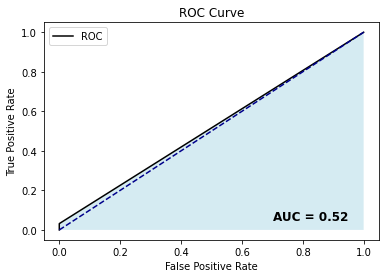

In [201]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_curve = roc_auc_score(y_test, y_pred)
plot_roc_curve(fpr, tpr)

## Decision Tree Regressor


I will also test the data using a Decision Tree Regressor, because we are looking through a binary decision classification. The use of Decision Tree could have a better or worst performance than K-Nearest Neighbors, but we will also use this tool to see what are the most important features.

In [107]:
tree  = DecisionTreeRegressor()

In [202]:
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [203]:
y_predict = tree.predict(X_test)
y_predict

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 1.

In [204]:
confusion_matrix(y_test, y_predict)

array([[171,  48],
       [ 66,  28]])

In [205]:
accuracy_score(y_test, y_predict)

0.6357827476038339

For the Decision Tree regressor we have a lower accuracy than with the KNN, but again if we look through the ROC Curve, we can see that despite having an AUC area greater than KNN, we are still too close to ramdomness, so sadly the model in this state can't be really use for predictions.

ROC Curve for Tree Regressor


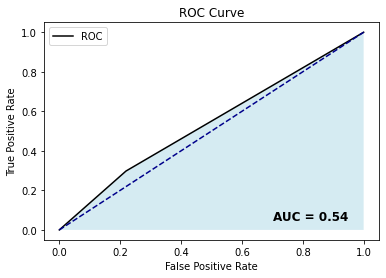

In [207]:
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
auc_curve = roc_auc_score(y_test, y_predict)
plot_roc_curve(fpr, tpr)

It's interesting to note that the three most important features for modeling the tree are MgrID, Age and Level, respectively, although for the correlation with Churn we had Level with higher correlations than both of first ones.

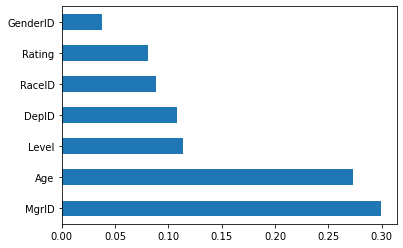

In [206]:
feat_importances = pd.Series(tree.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Conclusions

We could extract really interesting informations using the dataset presented here. Although through some departments we can see a discrepancy in ratings for gender and races, in the more global structure the company seem to tend more to the igualitarian distribuition.

We couldn't also see any real disparity when looking through the churn motivations, the distribuituion between gender is almost 50/50, same goes for race. When we look through the ages, some of then has a little higher chance for churning but not that can cause any alarm.


The modeling of the data and the possibilities too use a model to predict churn, could be achieve but we probably need more data to increase confidence, also other models that wasn't tested could have a better performance on the data. 

For the features that are important for modeling we age MgrID, Age and Level with the highest importance.